<a href="https://colab.research.google.com/github/E-Juliet/Movie-reccomender/blob/main/phase_4_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Reccomender System

## Business Understanding

### Problem Statement

Cinemy,a movie streaming company asked there users to rate them on google play store. The feedback received was that the movies recommended to the users didn't match their interests thus most customers were dissatisfied. 

They have approached us, a data analytics company to help them solve their problem. We will therefore, build a movie recommender system that will aid in suggesting top 5 movies to the streaming site users based on their ratings  and the genres they prefer.

### Metric for sucess

We will use RSME and MAE as our metric for success,the model having the lowest scores being our best model

### Data Understanding

The data used has been sourced from MovieLens dataset from the GroupLens research lab at the University of Minnesota.

It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users.

The dataset is distributed among four csv files:

* links.csv

* movies.csv

* ratings.csv

* tags.csv

__1.Movies.csv__

Each line of this file after the header row represents one movie, and has the following columns:

* movieId: Unique id for each movie
* title: Name of movies followed by their year of release
* genres: categories that a movie might fall into separated by |

__2.Links.csv__

The file `links.csv` contains indentifiers that can be used to link this data to other data sources like IMDb. Each line of this file after the header row represents one imdb link, and has the following columns:

* movieId: Unique id for each movie as used by https://movielens.org.
* imdbId: Unique id for each movie as used by http://www.imdb.com.
* tmdbId: Unique id for each movie as used by https://www.themoviedb.org.

__3.Tags.csv.__

 Each line of this file after the header row represents one tag applied to one movie by one user, and has the following columns:
* userId: Unique id for each user
movieId: Unique id for each movie
* tag: User-generated metadata about the movie in forms of short meaningful phrases
* timestamp: Time when tag was provided by user

__4.Ratings.csv__

Each line of this file after the header row represents one rating, and has the following columns:
* userId: Unique id for each user
* movieId: Unique id for each movie
* rating: Rating given by userId for movieId. Ratings are made on a 5-star scale with 0.5 increments.
* timestamp: Time when rating was given



In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# setting the font size for all plots
font = {'size': 16}

plt.rc('font', **font)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
tags_df = pd.read_csv('/content/drive/MyDrive/data/tags.csv')
movies_df = pd.read_csv('/content/drive/MyDrive/data/movies.csv')
ratings_df = pd.read_csv('/content/drive/MyDrive/data/ratings.csv')
links_df = pd.read_csv('/content/drive/MyDrive/data/links.csv')


### Reading the data

### links_df

In [4]:
display(links_df.head())
links_df.info()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


The links dataframe contains a movieid and also its id in imdb and tmbd

### movies_df

In [5]:
display(movies_df.head())
movies_df.info()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


movies df contains the movie id and also it's title plus the genre a certain movie belongs to.
The are no null values present here

### ratings_df

In [6]:
display(ratings_df.head())
ratings_df.info()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The rating df contains a user id, movie id and the ranking. Timestap here is irrelevant.

### tags_df

In [7]:
display(tags_df.head())
tags_df.info()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


The tags df contains the user id, movie id and also its tag.

In [8]:
# printing the number of records in every dataframe
dataframes = [links_df, movies_df, ratings_df, tags_df]
dataframe_names = ['links_df', 'movies_df', 'ratings_df', 'tags_df']

for i in range(len(dataframes)):
    print(f" {dataframe_names[i]} has {dataframes[i].shape[0]} records.")

 links_df has 9742 records.
 movies_df has 9742 records.
 ratings_df has 100836 records.
 tags_df has 3683 records.


tags_df has less values hence won't be appropriate to use it in this project. Also the same information present here is the same in the movie_df

## Data Cleaning

### movie_df
**the genres column**

for the genres column, I will change every value in every column to lower case and store them in a list

In [9]:
movies_df_cleaned = movies_df.copy()
movies_df_cleaned.genres = movies_df.genres.map(lambda x: x.replace('|', ',').lower().split(','))
movies_df_cleaned

,movieId,title,genres
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
1,2,Jumanji (1995),"[adventure, children, fantasy]"
2,3,Grumpier Old Men (1995),"[comedy, romance]"
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]"
4,5,Father of the Bride Part II (1995),[comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[action, animation, comedy, fantasy]"
9738,193583,No Game No Life: Zero (2017),"[animation, comedy, fantasy]"
9739,193585,Flint (2017),[drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[action, animation]"


### ratings_df, tags_df

**Removing the timestamp columns in both dataframes**

In [10]:
ratings_df_cleaned = ratings_df.drop('timestamp', axis=1)
tags_df_cleaned = tags_df.drop('timestamp', axis=1)

display(ratings_df_cleaned.head(2))
tags_df_cleaned.head(2)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable


This dataset has a total of 20 movie genres.

## EDA - Explanatory Data Analysis

### Univariative Data Analysis

#### Movies made per year

In [11]:
# extracting years from the title column
movies_df_cleaned['year'] = movies_df_cleaned['title'].str.extract('.*\((.*)\).*',expand = False)
movies_df_cleaned.year.unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', nan, '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', '2006–2007'], dtype=object)

There seems to be an off value ('2006--2007') and also a nan value

In [12]:
# checking record(s) that have 2006--2007 in the year column
movies_df_cleaned[movies_df_cleaned['year'] == "2006–2007"]

,movieId,title,genres,year
9518,171749,Death Note: Desu nôto (2006–2007),[(no genres listed)],2006–2007


In [13]:
# changing it to 2007
movies_df_cleaned.year = movies_df_cleaned.year.replace('2006–2007', '2007')
movies_df_cleaned[movies_df_cleaned['year'] == "2006–2007"]

,movieId,title,genres,year


In [14]:
# checking record(s) that contain null values in the year column
display(movies_df_cleaned[pd.isna(movies_df_cleaned.year)])
len(movies_df_cleaned[pd.isna(movies_df_cleaned.year)])

,movieId,title,genres,year
6059,40697,Babylon 5,[sci-fi],NaN
9031,140956,Ready Player One,"[action, sci-fi, thriller]",NaN
9091,143410,Hyena Road,[(no genres listed)],NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,[(no genres listed)],NaN
9179,149334,Nocturnal Animals,"[drama, thriller]",NaN
9259,156605,Paterson,[(no genres listed)],NaN
9367,162414,Moonlight,[drama],NaN
9448,167570,The OA,[(no genres listed)],NaN
9514,171495,Cosmos,[(no genres listed)],NaN
9515,171631,Maria Bamford: Old Baby,[(no genres listed)],NaN


12

In [15]:
# changing the data type of the year column to integer
movies_df_cleaned.year = movies_df_cleaned.year.dropna().astype(int)

# describing the cleaned movie datafram
movies_df_cleaned.year.describe()

count    9730.000000
mean     1994.614902
std        18.534692
min      1902.000000
25%      1988.000000
50%      1999.000000
75%      2008.000000
max      2018.000000
Name: year, dtype: float64

This dataset contains movie realeast between year 1902 and 2018

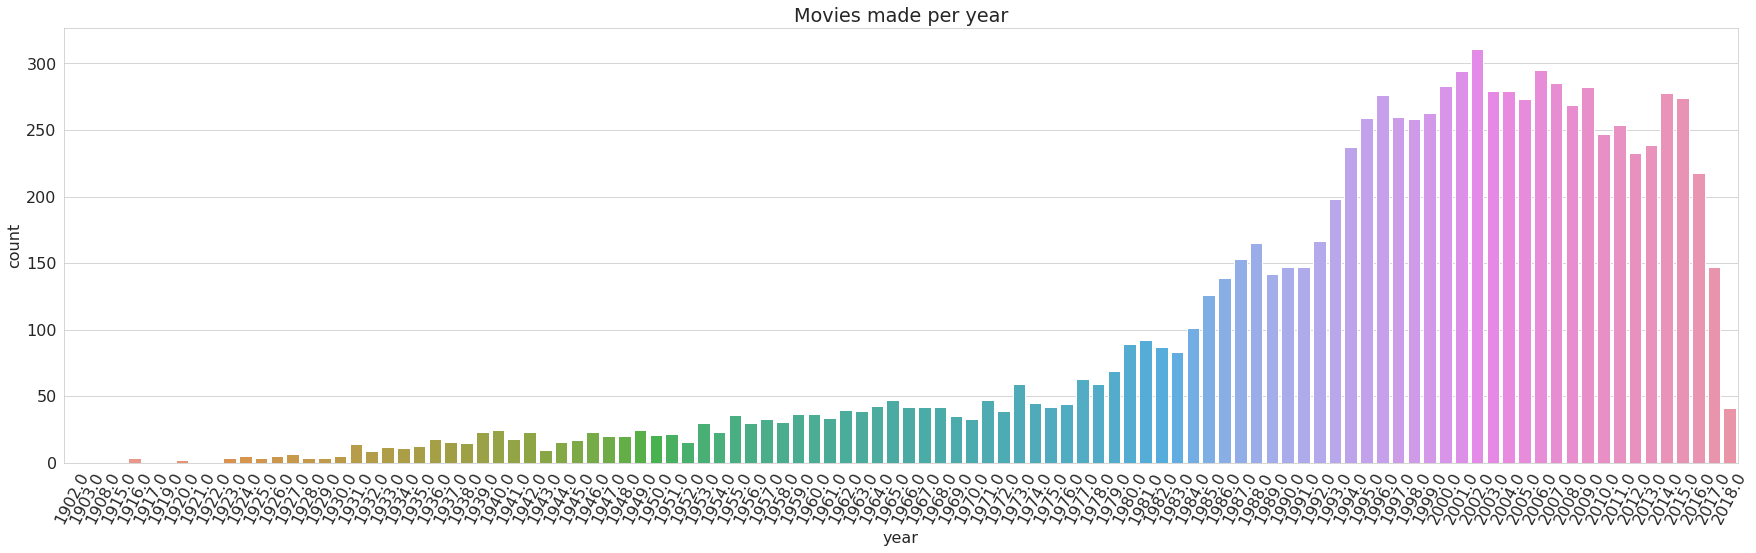

In [16]:
plt.figure(figsize=(30,8))
sns.countplot(x=movies_df_cleaned.year)
plt.xticks(rotation=63)
plt.title('Movies made per year')
plt.show()

#### Movies rating counts

In [17]:
ratings_df_cleaned['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

The ratings seem to range from 0 to 5

In [18]:
# investigating the range of ratings in the ratings df
ratings_df_cleaned['rating'].value_counts().to_frame()

,rating
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791
0.5,1370


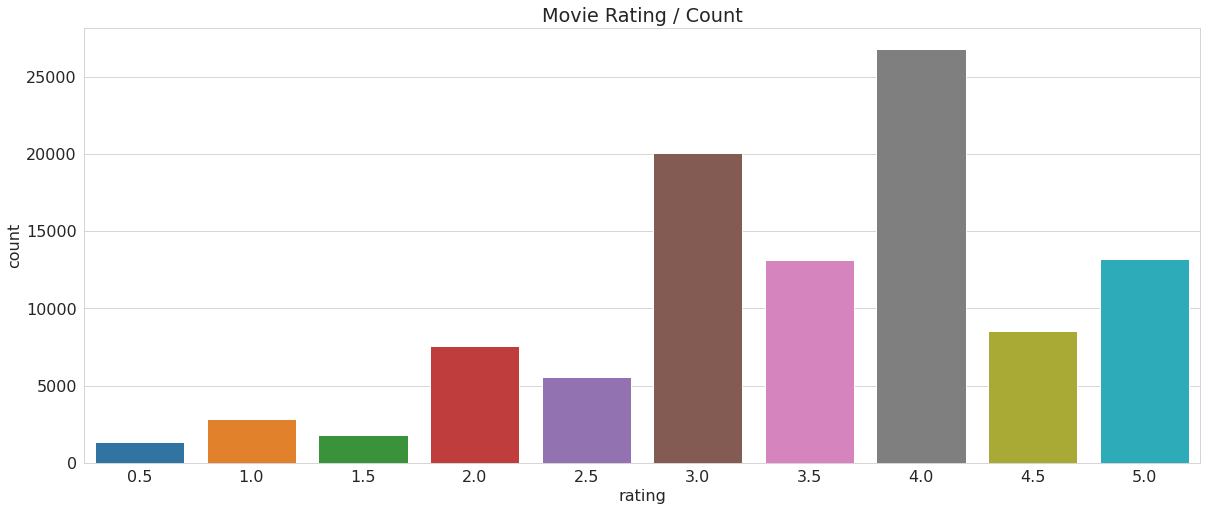

In [19]:
# Plotting a count plot of the ratings
plt.figure(figsize=(20,8))
sns.countplot(x=ratings_df_cleaned['rating'])
plt.title('Movie Rating / Count');
plt.show()

In [20]:
ratings_df_cleaned

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


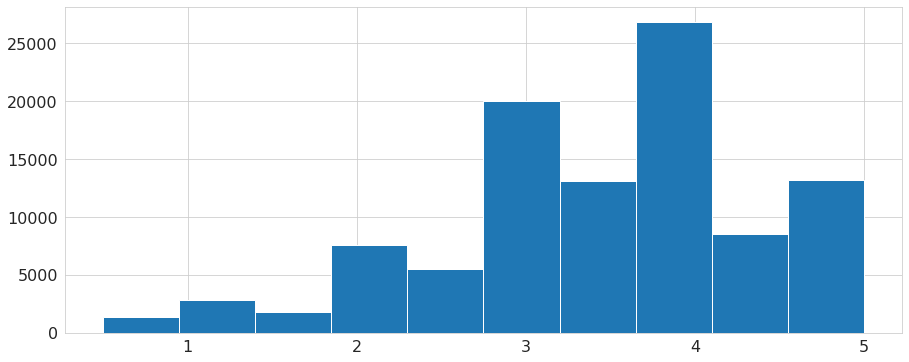

In [21]:
# checking the distribution plot
plt.figure(figsize=(15,6))
ratings_df_cleaned['rating'].hist(bins=10)
plt.show()

It can be deduced that rating given by users approximately 3.0 - 4.0 is the most common rating in the dataset. Also it seems to follow some kind of a normal distribution although there are some outliers


### Multivariate Data Analysis

### Genre average ratings

**Getting all the genres present in the dataset**

In [22]:
# creating a list to store the movie genres
genres = []

for record in range(len(movies_df_cleaned)):
    genres_list = movies_df_cleaned.loc[record, 'genres']

    for genre in genres_list:
        if genre not in genres:
            genres.append(genre)

In [23]:
movies_df_cleaned.loc[1, 'genres']

['adventure', 'children', 'fantasy']

In [24]:
movies_df_cleaned.loc[1, 'movieId']

2

In [25]:
r = ratings_df[ratings_df.movieId == 2]['rating'].mean()
r

3.4318181818181817

In [26]:
n = ratings_df[ratings_df.movieId == 2]['rating'].count()
n

110

In [27]:
genres_list = genres

In [28]:
#  creating a df to store the average ratings of every genre
genre_ratings_records = pd.DataFrame(index=genres, columns=['ratings'], data=np.zeros(len(genres)))
genre_ratings_records['no_records'] = np.zeros(len(genres))

for genre in genres:
    # iterating through every record to
    ratings = []
    no_records = 0
    for record in range(movies_df_cleaned.shape[0]):
        genres = movies_df_cleaned.loc[record, 'genres']

        if genre in genres:
            movie_id = movies_df_cleaned.loc[record, 'movieId']

            # fetching the ratings from the ratings df
            ratings.append(ratings_df[ratings_df.movieId == movie_id]['rating'].mean())
            no_records+=1
            

    genre_ratings_records.loc[genre, 'ratings'] = np.mean(ratings)
    genre_ratings_records.loc[genre, 'no_records'] = no_records

genre_ratings_sorted = genre_ratings_records
genre_ratings_sorted.head()

,ratings,no_records
adventure,NaN,1263.0
animation,NaN,611.0
children,3.10769,664.0
comedy,NaN,3756.0
fantasy,NaN,779.0


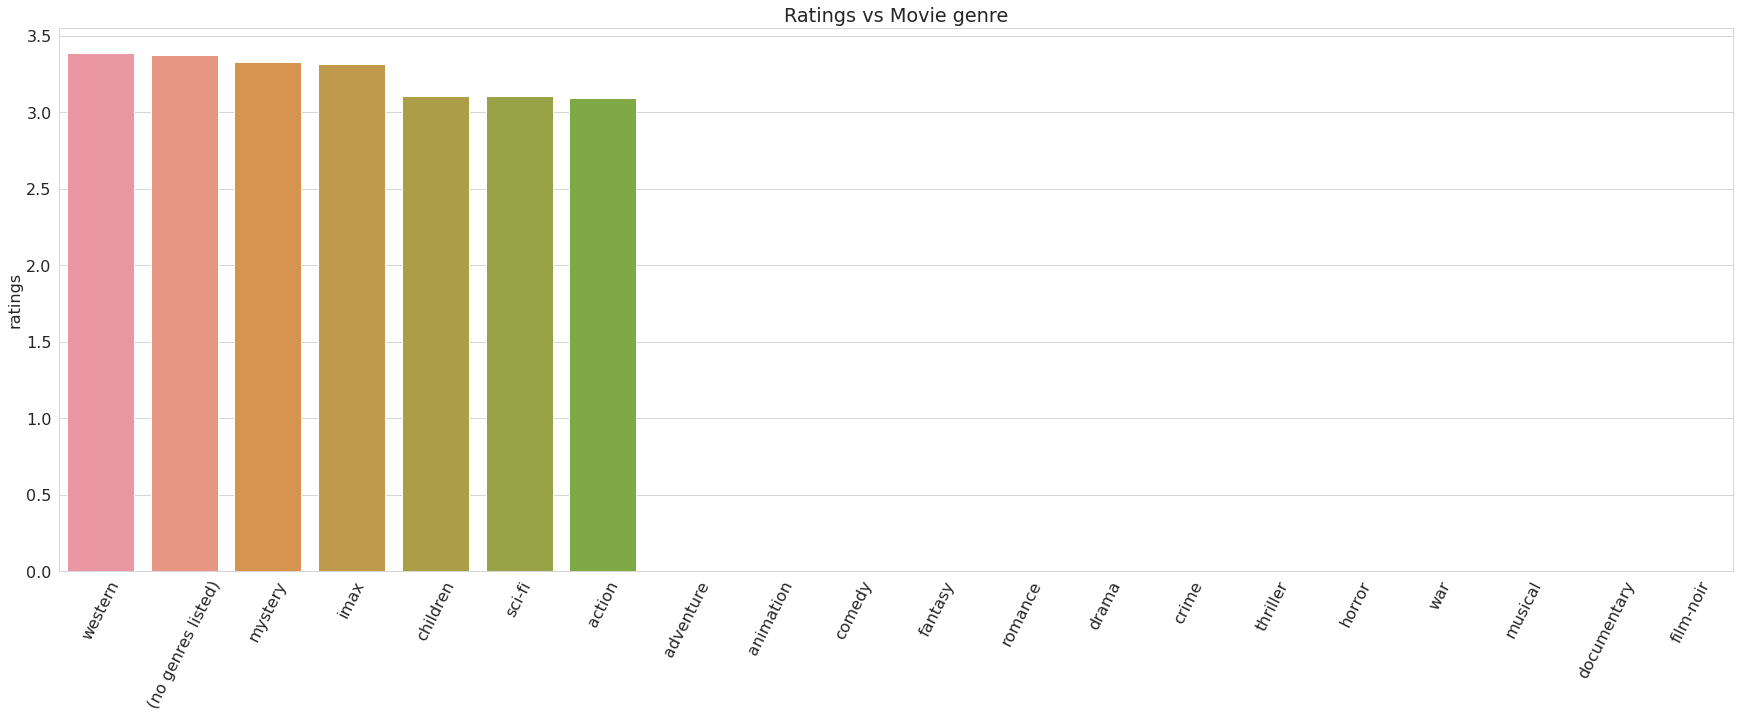

In [29]:
# printing the top 5 most ratied genres
plt.figure(figsize=(30,10))
sns.barplot(x=genre_ratings_sorted.sort_values('ratings', ascending=False).index, y=genre_ratings_sorted.sort_values('ratings', ascending=False).ratings)
plt.xticks(rotation=63)
plt.title('Ratings vs Movie genre')
plt.show()

From above we can see that the movies with the adventure genre have the highest average rating. Film-noil, comey seem to have a tie. The romance genre has the least ratings

### Total movies per genre

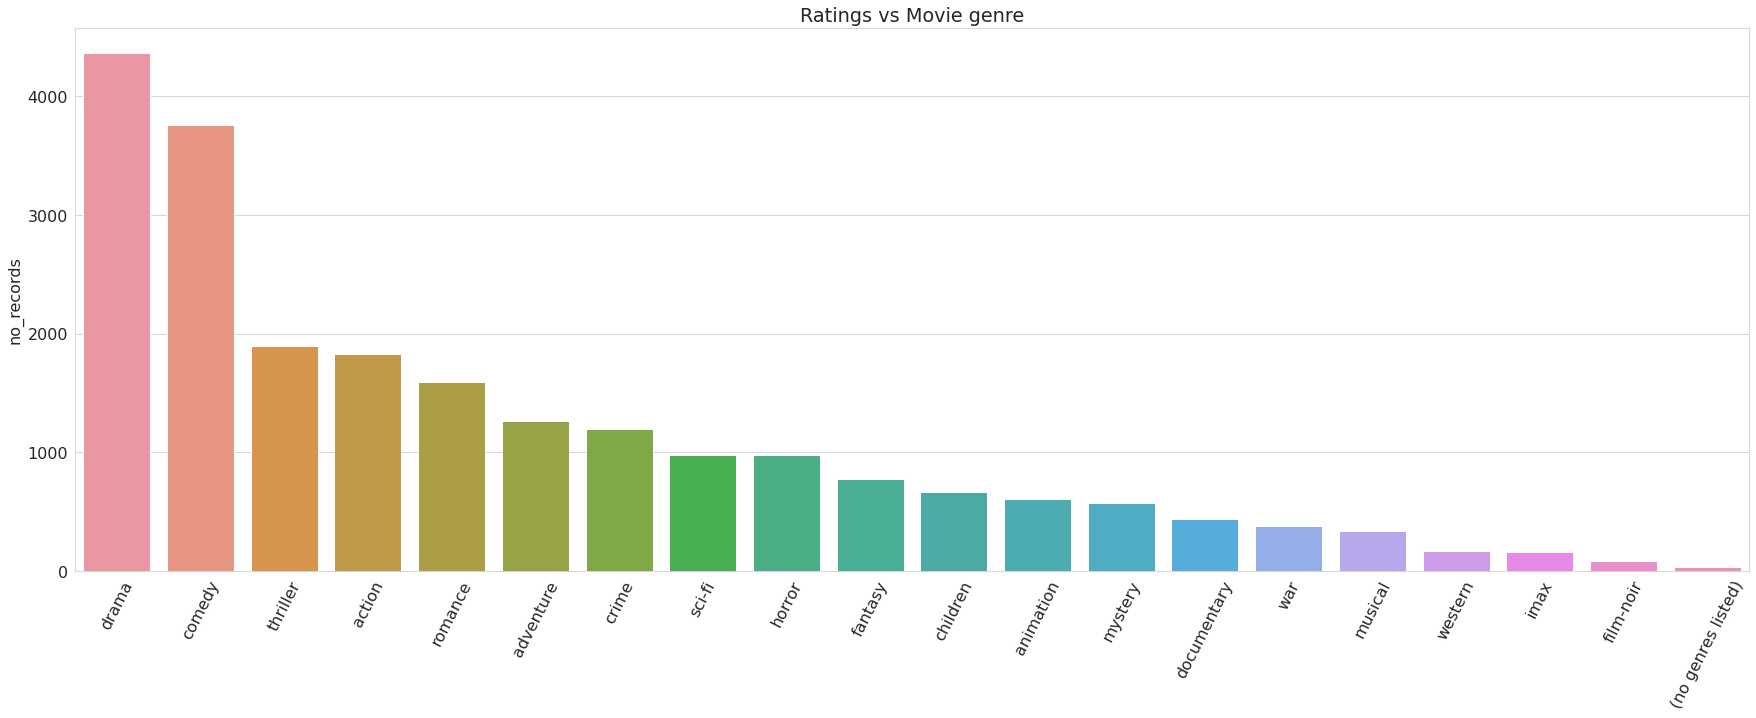

In [30]:
# printing the top 5 most ratied genres
plt.figure(figsize=(30,10))
sns.barplot(x=genre_ratings_sorted.sort_values('no_records', ascending=False).index, y=genre_ratings_sorted.sort_values('no_records', ascending=False).no_records)
plt.xticks(rotation=63)
plt.title('Ratings vs Movie genre')
plt.show()

In [31]:
# returning the movies_df_cleaned 
movies_df_cleaned.drop('year', axis=1, inplace=True)

### Making a master dataframe
We will merge different data frames to make a harmonised dataframe containing appropriate data. First lets have a look at the dataframes and how they can be merged together based on the criterions available.

In [32]:
movies_df_cleaned.shape

(9742, 3)

In [33]:
movies_df_cleaned.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [34]:
# movies with no ratings receive 0 as their average rating
mean_rating = ratings_df_cleaned.groupby('movieId').rating.mean().rename('mean rating')
num_rating = ratings_df_cleaned.groupby('movieId').userId.count().rename('num rating')

In [35]:
test_mean= pd.DataFrame(mean_rating, index= movies_df_cleaned.movieId)

In [36]:
test_num = pd.DataFrame(num_rating, index= movies_df_cleaned.movieId)

In [37]:
test_final = pd.merge(test_mean, test_num, on= "movieId")
test_final.head()

,mean rating,num rating
movieId,,
1,3.920930,215.0
2,3.431818,110.0
3,3.259615,52.0
4,2.357143,7.0
5,3.071429,49.0


In [38]:
df_final= pd.merge(movies_df_cleaned, test_final, on= "movieId")
df_final.head()

,movieId,title,genres,mean rating,num rating
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0
1,2,Jumanji (1995),"[adventure, children, fantasy]",3.431818,110.0
2,3,Grumpier Old Men (1995),"[comedy, romance]",3.259615,52.0
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]",2.357143,7.0
4,5,Father of the Bride Part II (1995),[comedy],3.071429,49.0


In [39]:
df_final.isna().sum()

movieId         0
title           0
genres          0
mean rating    18
num rating     18
dtype: int64

In [40]:
df_final[df_final["num rating"].isna()]

,movieId,title,genres,mean rating,num rating
816,1076,"Innocents, The (1961)","[drama, horror, thriller]",NaN,NaN
2211,2939,Niagara (1953),"[drama, thriller]",NaN,NaN
2499,3338,For All Mankind (1989),[documentary],NaN,NaN
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",[drama],NaN,NaN
3118,4194,I Know Where I'm Going! (1945),"[drama, romance, war]",NaN,NaN
4037,5721,"Chosen, The (1981)",[drama],NaN,NaN
4506,6668,"Road Home, The (Wo de fu qin mu qin) (1999)","[drama, romance]",NaN,NaN
4598,6849,Scrooge (1970),"[drama, fantasy, musical]",NaN,NaN
4704,7020,Proof (1991),"[comedy, drama, romance]",NaN,NaN
5020,7792,"Parallax View, The (1974)",[thriller],NaN,NaN


In [41]:
# dropping the null values
df_final.dropna(inplace= True)

In [42]:
# setting movie_id to be the index
df_final.set_index('movieId', inplace=True)

In [43]:
df_final.shape

(9724, 4)

#### One hot encoding the genres column

In [44]:
df_final.head()

,title,genres,mean rating,num rating
movieId,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0
2,Jumanji (1995),"[adventure, children, fantasy]",3.431818,110.0
3,Grumpier Old Men (1995),"[comedy, romance]",3.259615,52.0
4,Waiting to Exhale (1995),"[comedy, drama, romance]",2.357143,7.0
5,Father of the Bride Part II (1995),[comedy],3.071429,49.0


In [45]:
# selecting columns to be used for one hot encoding
genres_columns = genres_list[0:-1]

# creating genres columns and filling them with zeros
for genre in genres_columns:
    df_final[genre] = np.zeros(len(df_final))

# filling the genre columns with a 1 if the record exist and a 0 if the record does not exist
for movieId in df_final.index:
    rec_genres = df_final.loc[movieId, 'genres']

    for genre in rec_genres:
        df_final.loc[movieId, genre] = 1

In [46]:
# dropping the '(no genres listed)' column
df_final.drop('(no genres listed)', axis=1, inplace=True)
df_final.head()

,title,genres,mean rating,num rating,adventure,animation,children,comedy,fantasy,romance,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jumanji (1995),"[adventure, children, fantasy]",3.431818,110.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Grumpier Old Men (1995),"[comedy, romance]",3.259615,52.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Waiting to Exhale (1995),"[comedy, drama, romance]",2.357143,7.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Father of the Bride Part II (1995),[comedy],3.071429,49.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Investigating correlation between movies with higher number number of ratings and movies with average ratings

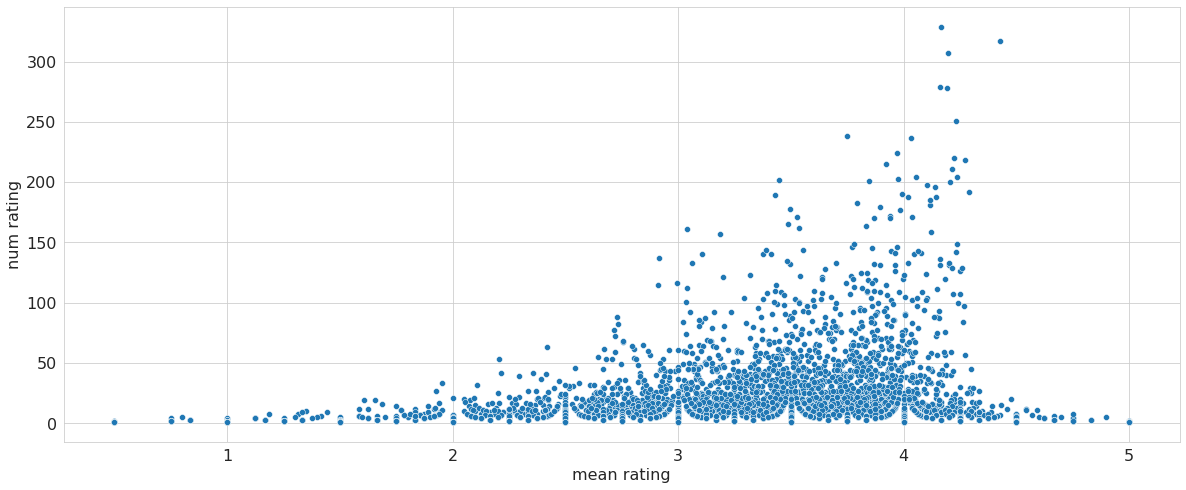

In [47]:
# mean rating and  total number of rating scatterplot
plt.figure(figsize=(20,8))
sns.scatterplot(data=df_final, x='mean rating', y ='num rating');

It can be deduced that movies that are good, also have a high number of ratings. Hence a correlation between the two.

## Naive Recommendation Engine

Naive Recommendation Engine will make use of the overall Ratings and genres in order to make movie recommendtions. This would be helpful especially when resolving Cold-start problem.
`Cold-start problem occurs when the system encounters new visitors to a website, with no browsing history or known preferences. creating a personalized experience for them becomes a challenge because the data normally used for generating recommendations is missing.`

`Solution`

For the first model we will recommend the top 10 most popular movies. i.e Movies with the most number of ratings that are highly rated.

In [57]:
#selecting specific columns from the final data frame.
#assign the columns to a new variable called user ratigs
user_ratings = df_final[['title', 'mean rating', 'num rating', ]]
user_ratings

,title,mean rating,num rating
movieId,,,
1,Toy Story (1995),3.920930,215.0
2,Jumanji (1995),3.431818,110.0
3,Grumpier Old Men (1995),3.259615,52.0
4,Waiting to Exhale (1995),2.357143,7.0
5,Father of the Bride Part II (1995),3.071429,49.0
...,...,...,...
193581,Black Butler: Book of the Atlantic (2017),4.000000,1.0
193583,No Game No Life: Zero (2017),3.500000,1.0
193585,Flint (2017),3.500000,1.0


In [61]:
#sort the new dataFrame by number of ratings from highest to lowest
#Top 10 movies by its number of ratings
user_ratings.sort_values(by=['num rating'], ascending=False).head(10)

,title,mean rating,num rating
movieId,,,
356,Forrest Gump (1994),4.164134,329.0
318,"Shawshank Redemption, The (1994)",4.429022,317.0
296,Pulp Fiction (1994),4.197068,307.0
593,"Silence of the Lambs, The (1991)",4.161290,279.0
2571,"Matrix, The (1999)",4.192446,278.0
260,Star Wars: Episode IV - A New Hope (1977),4.231076,251.0
480,Jurassic Park (1993),3.750000,238.0
110,Braveheart (1995),4.031646,237.0
589,Terminator 2: Judgment Day (1991),3.970982,224.0


The above dataFrame shows the movies with the highest number of Rating. Lets also analyse the movies with the highest rating.


In [60]:
# top 10 movies by its mean ratings
user_ratings.sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
movieId,,,
88448,Paper Birds (Pájaros de papel) (2010),5.0,1.0
100556,"Act of Killing, The (2012)",5.0,1.0
143031,Jump In! (2007),5.0,1.0
143511,Human (2015),5.0,1.0
143559,L.A. Slasher (2015),5.0,1.0
6201,Lady Jane (1986),5.0,1.0
102217,Bill Hicks: Revelations (1993),5.0,1.0
102084,Justice League: Doom (2012),5.0,1.0
6192,Open Hearts (Elsker dig for evigt) (2002),5.0,1.0


The above dataFrame does not provide very useful information the recomender since some movies might have only been rated by one user thus its average rating being 5. We have to also consider movies that have a higher average rating that have been rated by many users.

In the cell below we will analyse top 10 highly rated movies that have been rated by 200 users`200 num of ratings`

In [62]:
#creating minimum number of ratings
#find the most popular movies in the data frame.
threshold = 200
user_ratings[user_ratings['num rating']>threshold ].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
movieId,,,
318,"Shawshank Redemption, The (1994)",4.429022,317.0
2959,Fight Club (1999),4.272936,218.0
50,"Usual Suspects, The (1995)",4.237745,204.0
260,Star Wars: Episode IV - A New Hope (1977),4.231076,251.0
527,Schindler's List (1993),4.225000,220.0
1196,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211.0
296,Pulp Fiction (1994),4.197068,307.0
2571,"Matrix, The (1999)",4.192446,278.0
356,Forrest Gump (1994),4.164134,329.0


The dataframe above finaly gives the most popular movies which are also loved by most users.

To further refine our recommendations we will use Genre information from the final EDA dataFrame.` A user might want to be recommended a specific genre e.g Animation` Hence the need to refine the recommendation to the users preference

In [64]:
#using the final data frame from EDA
df_final.head()

,title,genres,mean rating,num rating,adventure,animation,children,comedy,fantasy,romance,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jumanji (1995),"[adventure, children, fantasy]",3.431818,110.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Grumpier Old Men (1995),"[comedy, romance]",3.259615,52.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Waiting to Exhale (1995),"[comedy, drama, romance]",2.357143,7.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Father of the Bride Part II (1995),[comedy],3.071429,49.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# selecting the top movies given a certain genre and number of rating threshold 
genre = 'animation'
rating_thresh = 200
df_final[(df_final[genre] == 1) & (df_final['num rating']>rating_thresh)].sort_values(by=['mean rating'], ascending=False).head(10)

,title,genres,mean rating,num rating,adventure,animation,children,comedy,fantasy,romance,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.92093,215.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Naive Recommendation for a new user**

Building the basic Recommendation Engine.

- For cases where there is no information for users, the recommender will recommend movies rated more than the set threshold with the highest rating.
- For cases where the user wants recommendation for specific genre, the recommender will recommend only movies from that specified genre that have the highest rating 

In [54]:
def recommender(genre, threshold=10):
    # getting the last record
    rating_thresh = list(df_final[ df_final[genre] == 1 ]['num rating'].to_frame().sort_values('num rating', ascending=False)['num rating'][:threshold*2])[-1]

    if genre == 'all':
      result = user_ratings.sort_values(by=['num rating'], ascending=False).head(threshold)
    else:
      result = df_final[(df_final[genre] == 1) & (df_final['num rating']>=rating_thresh)].sort_values(by=['mean rating'], ascending=False).head(threshold)
    
    print('\n\nThese are the recommendations for the users with the following filters')
    print('Minimum number of ratings:',threshold)
    print("User's choice of genre:",genre)
    display(result)

In [55]:
recommender('animation',5)



These are the recommendations for the users with the following filters
Minimum number of ratings: 5
User's choice of genre: animation


,title,genres,mean rating,num rating,adventure,animation,children,comedy,fantasy,romance,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
movieId,,,,,,,,,,,,,,,,,,,,,
60069,WALL·E (2008),"[adventure, animation, children, romance, sci-fi]",4.057692,104.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
68954,Up (2009),"[adventure, animation, children, drama]",4.004762,105.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6377,Finding Nemo (2003),"[adventure, animation, children, comedy]",3.960993,141.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364,"Lion King, The (1994)","[adventure, animation, children, drama, musica...",3.941860,172.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Colloborative Filtering

### Content-Based Recommender

A content based recommender works with data that the user provides, either explicitly `rating` or implicitly `clicking on a link`. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

- For this second Recommender Engine we will use correlation between the ratings assigned to different movies,in order to find the similarity between the movies.
- Now lts create a matrix that has the `userID` on one axis and `movie title` on another axis.Each cell will then consist of the ratings the user gave to the movie.
- `NOTE` There will be a lot of NAN values in the cells, because most people have not seen most of the movies